# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# Создадим словарь описания данных
data_descr = {
    'age': 'возраст держателя карты',
    'job': 'сфера занятости',
    'marital': 'семейное положение',
    'education': 'уровень образования',
    'default': 'наличие просроченного кредита',
    'housing': 'имеется ли кредит на жилье',
    'loan': 'имеется ли кредит на личные нужды',
    'balance': 'баланс',
    'contact': 'тип контакта с клиентом',
    'month':  'месяц, в котором был последний контакт',
    'day': 'день, в который был последний контакт',
    'duration': 'продолжительность контакта в секундах',
    'campaign': 'количество состоявшихся контактов в текущей компании',
    'pdays': 'количество дней, пропущенных с момента последней маркетинговой кампании до контакта в текущей кампании',
    'previous': 'количество контактов до текущей кампании',
    'poutcome': 'результат прошлой маркетинговой кампании',
    'deposit': 'клиент согласился открыть депозит'
}

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Видим пропуски только в признаке balance в количестве 25 шт.

### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Есть пропуски данных, но они обозначены строкой "unknown", что позволяет использовать этот признак в машинном обучении в отличие от np.nan. Всего имеется 70 строк данных с таким значением в признаке job.

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
import numbers

def get_balance(balance: str) -> float:
    """
    Return a float value of balance presetnted as a '1 250,00 $' string

    Args:
        balance (str): input string or float value

    Returns:
        float: balance
    """

    if isinstance(balance, numbers.Number):
        return float(balance)
    
    return float(balance.replace(' ', '').replace(',', '.')[:-1])

display(df['balance'].head())

df['balance'] = df['balance'].apply(get_balance)

display(df['balance'].describe())

print(f'Пропущено {df["balance"].isna().sum()} значений в признаке balance')


0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

Пропущено 25 значений в признаке balance


### Задание 4

In [8]:
# обработайте пропуски в признаке balance , заменив их на медианные значения по данному признаку
# ваш код
balance_mediian = df['balance'].median()
df['balance'].fillna(balance_mediian, inplace=True)
print(f'Пропущено {df["balance"].isna().sum()} значений в признаке balance')


Пропущено 0 значений в признаке balance


### Задание 2.4
1 point possible (graded)

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [9]:
print(f'Среднее значение balance: {df["balance"].mean():.3f}')

Среднее значение balance: 1526.936


### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode().values[0]
df.loc[(df['job'] == 'unknown'), 'job'] = job_mode
print(f'Пропущено {(df["job"] == "unknown").sum()} значений в признаке job')
education_mode = df['education'].mode().values[0]
df.loc[(df['education'] == 'unknown'), 'education'] = education_mode
print(f'Пропущено {(df["education"] == "unknown").sum()} значений в признаке education')


Пропущено 0 значений в признаке job
Пропущено 0 значений в признаке education


### Задание 2.5
1 point possible(graded)

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования(т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.


In [11]:
mean_balance = df[
    (df['job'] == job_mode) & (df['education'] == education_mode)
]['balance'].mean()
print(f'Средний баланс держатель карт с самой популярной работой {job_mode} \
и самым популярным образованием {education_mode}: {mean_balance:.3f}')

Средний баланс держатель карт с самой популярной работой management и самым популярным образованием secondary: 1598.883


### Задание 6

### Задание 2.6
2 points possible (graded)

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

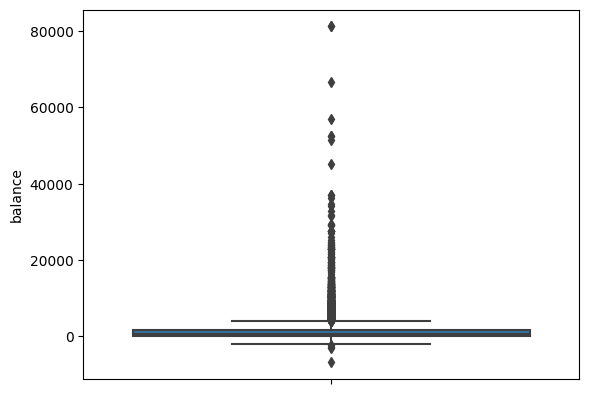

In [12]:
# удалите все выбросы для признака balance
# ваш код
sns.boxplot(y=df['balance'])

def outliers_iqr(df, feature, log_scale=False, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    x = df[feature]

    if log_scale:
        x = np.log(x)

    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = df[(x < lower_bound) | (x > upper_bound)].copy()
    cleaned = df[(x >= lower_bound) & (x <= upper_bound)].copy()
    info = f'Выбросы: {outliers.shape[0]} строк ({outliers.shape[0] / df.shape[0] * 100:.2f}%).'

    return info, outliers, cleaned, lower_bound, upper_bound

In [13]:
report, outliers, df_clean, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(report)
print(f'Нижняя граница метода Тьюки: {lower_bound:.0f}')
print(f'Верхняя граница метода Тьюки: {upper_bound:.0f}')


Выбросы: 1057 строк (9.47%).
Нижняя граница метода Тьюки: -2241
Верхняя граница метода Тьюки: 4063


Как видно по ящику с усами, выбросов в признаке 'balance' не мало. Действительно, по методу Тьюки (метод интерквартильного размаха) мы вычистили 1057 строк данных, что составило почти 10% датасета.

### Задание 2.7
1 point possible(graded)

Сколько объектов осталось после удаления всех выбросов?


In [14]:
df_clean.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

[Text(0.5, 1.0, 'Соотношение количества примеров для каждого варианта целевой переменной deposit')]

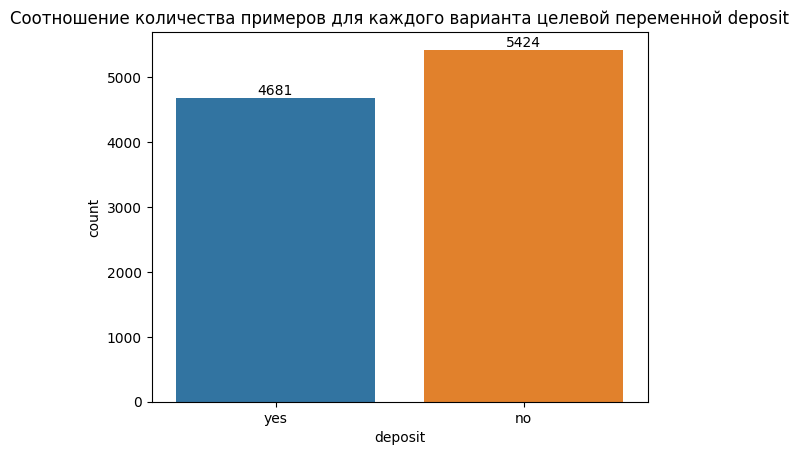

In [15]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df = df_clean
ax = sns.countplot(x='deposit', data=df)
ax.bar_label(ax.containers[0])
ax.set(title='Соотношение количества примеров для каждого варианта целевой переменной deposit')

Видим, что классы практически сбалансированы. Однако для лучшей точности модели будем применять стратификацию при разделении данных на тренировочную и тестовую выборки.

### Задание 3.1
1 point possible (graded)

Сколько клиентов открыли депозит?

In [16]:
(df['deposit'] == 'yes').sum()

4681

### Задания 2 и 3

In [17]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe(include=np.number)

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Пока не очень информативно. Посмотрим на распределения графически

In [18]:
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plot = px.box(df, y=col, title=f'Распределение признака {col} ({data_descr[col]})')
    plot.show()

#### Выводы:
* Максимальный возраст клиента 95 лет;
* 41 и 43 контакта в текущей компании - явный перебор;
* Минус один день с момента последней маркетинговой компании явный выброс, который в прочем может означать то, что обращение к этому клиенту по прошлым компаниям не осуществлялось и текущая компания первая. Проверить это можно проанализировав записи со значением pdays == -1 в разрезе результата предыдущей компании poutcome;
* Видим выбросы во всех признаках, кроме day (это порядковый номер дня в месяце и значения ограничены диапазоном от 1 до 31);
* В признаках duration, campaign, pdays, previous выбросов наблюдается особенно много;
* Вызывает сомнение 3881 секудна контакта с клиентом в признаке duration (в часе всего 3600 сек). Это значение и многие похожие являются явными выбросами. Потребуется дополнительная обработка этих признаков.

### Задания 4 и 5

In [19]:
import plotly
plotly.__version__

'5.9.0'

In [20]:
def plot_counts(df, col: str, section: str) -> None:
    """
    Plot counts of values in col with additional grouping by section

    Args:
        df (pandas.DataFrame): Dataframe
        col (str): name of column to count and plot frequencies
        section (str): section to group
    """
    
    plot = px.histogram(
        df,
        x=col,
        title=f'Частоты значений признака {col} ({data_descr[col]}) в разрезе {section}',
        color=section
    )

    plot.update_xaxes(categoryorder="total descending")
    plot.show()


In [21]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
display(df.drop(columns=['deposit']).describe(include='object'))
#постройте визуализации, иллюстрирующие результаты
categorical_cols = df.select_dtypes(include='object').columns[:-1]
for col in categorical_cols:
    plot_counts(df, col, 'deposit')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


#### Выводы:
* По сфере занятости на первом месте идёт менеджмент, за ними рабочий класс, техники и администраторы. Самая малочисленная группа - домохозяйки. Количество отказов открыть депозит превалирует над количеством согласий во всех группах, кроме пенсионеров, безработных и студентов;
* В данных больше всего клиентов состоящих в браке. Самая малочисленная группа - разведенные. Количество согласий открыть депозит больше, чем количество отказов только в группе одиноких людей;
* Больше всего клиентов в предоставленном наборе данных имеет среднее образование, на втором месте высшее образование. Количество согласий открыть депозит больше, чем количество отказов только в группе людей с высшим образованием;
* Подавляющее большинство клиентов не имеет просроченных кредитов. Среди них, как и среди имеющих просроченные кредиты количество отказов по депозиту больше, чем согласий;
* Количества клиентов имеющих кредиты на жилье практически совпадает с количеством не имеющих таких кредитов. При этом количество согласий по депозиту больше чем отказов в группе не имеющих таких кредитов;
* Большинство клиентов не имеет кредитов на личные нужды. В обеих группах количество отказов выше количества согласий по депозитам;
* В типе контакта с клиентом присутствует пропуск в виде значения 'unknown'. При этом количесто отказов в этой группе превышает количество согласий по депозиту в отличие от самой многочисленной группы 'celular'. К группе 'telephone' количество отказов также выше, чем количество согласий по депозиту. Предлагаю переименовать значения 'unknown' в 'other' и рассматривать как отдельную, третью группу по способу коммуникации;
* В отношении месяцев видим, что согласий больше чем отказов по депозитам было в феврале, марте, апреле, сентябре, октябре и декабре. Интересно было бы разобраться, с чем это связано в жизненном укладе клиентов;
* В отношении результата предыдущей компании, количество согласий больше количества отказов по депозиту в группе 'success'. Это говорит о том, что люди, которые ранее воспользовались предложением банка охотно делают это повторно. Видимо продукт действительно приносит пользу

### Задание 6

### Задание 3.6
1/1 point (graded)

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

Внимание! Используемый в дальшейшем параметр allow_duplicates метода pandas.Series.reset_index появился начиная с версии 1.5.0. Если ваша версия старее, то потребуется обновить pandas.

In [22]:
#pip install -U pandas

In [23]:
pd.__version__

'2.0.1'

In [24]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
results_df = df.groupby(['poutcome'])['deposit']\
    .value_counts(normalize=True)\
        .reset_index(allow_duplicates=True)
        
results_df[(results_df['deposit'] == 'yes') & (results_df['proportion'] > 0.5)]\
    .sort_values('proportion', ascending=False)['poutcome'].values[0]

'success'

### Задание 7

In [25]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
results_df = df.groupby(['month'])['deposit']\
    .value_counts(normalize=True)\
    .reset_index(allow_duplicates=True)

results_df[(results_df['deposit'] == 'no') & (results_df['proportion'] > 0.5)]\
    .sort_values('proportion', ascending=False)['month'].values[0]


'may'

### Задание 8

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'.

Совет. После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

Мой комментарий: так обозначать и разделять группы неверно, так как границы групп пересекаются. Буду разделять на группы:
* '<30';
* '30-39';
* '40-49';
* '50-59';
* '60+'.


In [26]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_group(age: int) -> str:
    """
    Return one of age groups:
        * '<30';
        * '30-39';
        * '40-49';
        * '50-59';
        * '60+'.
    according to age.


    Args:
        age (int): age in years

    Returns:
        str: group name
    """
    
    if age < 30:
        return '<30'

    if age <= 39:
        return '30-39'

    if age <= 49:
        return '40-49'

    return '50-59' if age <= 59 else '60+'

In [27]:
df['age_group'] = df['age'].apply(get_age_group)

In [28]:
data_descr['age_group'] = 'возрастная группа'

In [29]:
plot_counts(df, 'age_group', 'deposit')

### Задание 3.8
1 point possible (graded)

Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

* A '<30' верно
* B '30-40'
* C '40-50'
* D '50-60'
* E '60+' верно



### Задания 9 и 10

### Задание 3.10
1 point possible (graded)

При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plot_counts(df, 'marital', 'deposit')

Ответ: single

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plot_counts(df, 'education', 'deposit')

### Задание 3.9
1 point possible (graded)
В какой сфере занято наибольшее число клиентов банка?

In [32]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plot_counts(df, 'job', 'deposit')

Ответ: management

### Задание 11

In [62]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)
success_df = df[df['deposit'] == 'yes']\
    .groupby(['education', 'marital'])['marital']\
    .value_counts()\
    .reset_index()\
    .pivot(index='education', columns='marital', values='count')
plot = px.imshow(
    success_df,
    text_auto=True,
    title='Тепловая карта количества людей в разрезе семейного положения и образования среди согласившихся открыть депозит')
plot.show()

fail_df = df[df['deposit'] == 'no']\
    .groupby(['education', 'marital'])['marital']\
    .value_counts()\
    .reset_index()\
    .pivot(index='education', columns='marital', values='count')
plot = px.imshow(
    fail_df,
    text_auto=True,
    title='Тепловая карта количества людей в разрезе семейного положения и образования среди отказавшихся открыть депозит')
plot.show()


### Задание 3.11
2 points possible (graded)

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

Пересечение каких двух категорий является самым многочисленным?

Ответ: secondary и married

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna